### Block  1 – Part 1 – “How good are the raw continuous scores?”

__(iii)__ check how well their ranks track functional truth in the DMS subset. 

*Take‑home: a ranking of the five continuous tools and a quick sense of which ones give complementary information.*

In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, os, re
from matplotlib.lines import Line2D
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import spearmanr, pearsonr

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', None)

### DMS performance (Mutagenesis data)

In [78]:
dms_data = pd.read_csv("~/Desktop/analysis files/DMS data/mutagenesis_dms_data.csv", index_col=0)

In [110]:
dms_data.head(3)

,normalized_fitness,uniprot,variant,QAFI,gene_name
0,-0.252455,A0PJY2,V289A,0.804,FEZF1
1,-0.801103,A0PJY2,V289C,0.704,FEZF1
2,0.213685,A0PJY2,V289D,0.720,FEZF1


In [80]:
dms_data.drop([c for c in dms_data.columns if c not in ['normalized_fitness', 'uniprot', 'GeneSymbol', 'variant', 'qafi1']], axis=1, inplace=True)

In [81]:
dms_data.rename(columns={'qafi1': 'QAFI', 'GeneSymbol': 'gene_name'}, inplace=True)

In [82]:
dms_data.columns

Index(['normalized_fitness', 'uniprot', 'variant', 'QAFI', 'gene_name'], dtype='object')

In [83]:
dms_data.to_csv("~/Desktop/analysis files/DMS data/mutagenesis_dms_data_cleaned.csv", index=False)

##### Add missing preds (EVE, CADD, Envision, MetaRNN)

In [87]:
dms_data = pd.read_csv("~/Desktop/analysis files/DMS data/mutagenesis_dms_data_cleaned.csv")

In [90]:
dms_data.shape

(493278, 5)

##### EVE

In [91]:
eve_preds = pd.read_csv("~/Desktop/analysis files/DMS data/SupplementaryTable5.txt", sep='\t')

In [92]:
eve_preds.columns

Index(['domain_ID', 'uniprot_ID', 'uniprot_ID_mutation', 'aa_seq', 'fitness',
       'fitness_sigma', 'scaled_fitness', 'scaled_fitness_sigma',
       'ESM1v_domain', 'RaSP', 'ddmut', 'FoldX', 'popEVE', 'EVE',
       'Tranception', 'EVE_domain', 'rsasa', 'thermoMPNN', 'AlphaMissense',
       'ESM1v_full-length', 'Organism', 'Gene Names (primary)',
       'Gene Names (synonym)'],
      dtype='object')

In [93]:
eve_preds['variant'] = eve_preds['uniprot_ID_mutation'].str.split('_').str[1]

In [94]:
eve_preds.shape

(607081, 24)

In [95]:
with open(os.path.expanduser('~/Desktop/analysis files/DMS data/uniprot_ids.txt')) as f:
    ids = [line.strip() for line in f]

eve_preds = eve_preds[eve_preds['uniprot_ID'].isin(ids)][['variant', 'uniprot_ID', 'EVE']]

In [96]:
eve_preds.rename(columns={'uniprot_ID': 'uniprot'}, inplace=True)

In [97]:
eve_preds.columns

Index(['variant', 'uniprot', 'EVE'], dtype='object')

In [98]:
eve_preds.shape

(568093, 3)

In [99]:
# remove duplicates
eve_preds = eve_preds.drop_duplicates(subset=['uniprot', 'variant'])

# remove rows where variant alt is '*'
eve_preds = eve_preds[~eve_preds['variant'].str.endswith('*')]

In [100]:
eve_preds.shape

(531566, 3)

In [101]:
eve_preds.to_csv("~/Desktop/analysis files/DMS data/EVE_selected.csv", index=False)

In [102]:
dms_data2 = dms_data.merge(eve_preds[['uniprot', 'variant', 'EVE']], on=['uniprot', 'variant'], how='left')

In [103]:
dms_data2.shape

(493278, 6)

In [104]:
dms_data2.columns

Index(['normalized_fitness', 'uniprot', 'variant', 'QAFI', 'gene_name', 'EVE'], dtype='object')

In [106]:
dms_data2 = dms_data2[['gene_name', 'uniprot', 'variant', 'normalized_fitness', 'EVE', 'QAFI']]

In [107]:
dms_data2.isna().sum()

gene_name                 0
uniprot                   0
variant                   0
normalized_fitness        0
EVE                   48866
QAFI                      0
dtype: int64

In [135]:
dms_data2['normalized_fitness'] *= -1
dms_data2['QAFI'] *= -1

In [137]:
dms_data2.to_csv("~/Desktop/analysis files/DMS data/mutagenesis_dms_data_cleaned2.csv", index=False)

In [3]:
dms_data2 = pd.read_csv("~/Desktop/Mutagenesis data + Preds/mutagenesis_dms_data_cleaned2.csv")

In [6]:
dms_data2.head(3)

,gene_name,uniprot,variant,normalized_fitness,EVE,QAFI
0,FEZF1,A0PJY2,V289A,0.252455,7.421,-0.804
1,FEZF1,A0PJY2,V289C,0.801103,8.002,-0.704
2,FEZF1,A0PJY2,V289D,-0.213685,8.979,-0.720


In [7]:
dms_data2.shape

(493278, 6)

##### Envision

In [4]:
envision_preds = pd.read_csv("~/Desktop/Mutagenesis data + Preds/Envision_selected.csv")

/tmp/ipykernel_1472716/641725998.py:1: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  envision_preds = pd.read_csv("~/Desktop/Mutagenesis data + Preds/Envision_selected.csv")


In [5]:
envision_preds.head(3)

,Uniprot,Variant,Envision_predictions
0,NaN,NaN,NaN
1,Q9H920,H76M,0.777403
2,Q9H920,H76N,0.866815


In [8]:
envision_preds.shape

(239574196, 3)

In [9]:
envision_preds.rename(columns={'Uniprot': 'uniprot', 'Variant': 'variant', 'Envision_predictions': 'Envision'}, inplace=True)

In [10]:
envision_preds.columns

Index(['uniprot', 'variant', 'Envision'], dtype='object')

In [11]:
dms_data3 = dms_data2.merge(envision_preds, on=['uniprot', 'variant'], how='left')

In [12]:
dms_data3.shape

(537314, 7)

In [13]:
dms_data3 = dms_data3.drop_duplicates()

In [14]:
dms_data3.shape

(493278, 7)

In [16]:
dms_data3["Envision"] *= -1
dms_data3.head(3)

,gene_name,uniprot,variant,normalized_fitness,EVE,QAFI,Envision
0,FEZF1,A0PJY2,V289A,0.252455,7.421,-0.804,-0.855814
1,FEZF1,A0PJY2,V289C,0.801103,8.002,-0.704,-0.751929
2,FEZF1,A0PJY2,V289D,-0.213685,8.979,-0.720,-0.759098


In [17]:
dms_data3.to_csv("~/Desktop/Mutagenesis data + Preds/mutagenesis_dms_data_cleaned3.csv", index=False)

In [3]:
dms_data3 = pd.read_csv("~/Desktop/Mutagenesis data + Preds/mutagenesis_dms_data_cleaned3.csv")

##### MetaRNN

In [28]:
metarnn_preds = pd.read_csv("~/Desktop/Mutagenesis data + Preds/MetaRNN_selected.tsv", sep='\t')

In [5]:
metarnn_preds.head(3)

,aaref,aaalt,aapos,genename,Uniprot_acc,MetaRNN_score
0,M,L,1,OR4F5,A0A2U3U0J3,0.3169853
1,M,V,1,OR4F5,A0A2U3U0J3,0.3184599
2,M,L,1,OR4F5,A0A2U3U0J3,0.31631923


In [29]:
metarnn_preds.shape

(84428788, 6)

In [30]:
metarnn_preds['variant'] = metarnn_preds['aaref'] + metarnn_preds['aapos'].astype(str) + metarnn_preds['aaalt']

In [31]:
metarnn_preds.columns

Index(['aaref', 'aaalt', 'aapos', 'genename', 'Uniprot_acc', 'MetaRNN_score',
       'variant'],
      dtype='object')

In [32]:
metarnn_preds = metarnn_preds.drop(columns=['aaref', 'aaalt', 'aapos', 'genename'])

In [33]:
metarnn_preds.rename(columns={'Uniprot_acc': 'uniprot', 'MetaRNN_score': 'MetaRNN'}, inplace=True)

In [34]:
metarnn_preds = metarnn_preds.drop_duplicates(subset=['uniprot', 'variant'])

In [35]:
metarnn_preds.shape

(73141699, 3)

In [36]:
dms_data4 = dms_data3.merge(metarnn_preds[['uniprot', 'variant', 'MetaRNN']], on=['uniprot', 'variant'], how='left')

In [37]:
dms_data4.shape

(493278, 8)

In [40]:
dms_data4.isna().sum()

gene_name                  0
uniprot                    0
variant                    0
normalized_fitness         0
EVE                    48866
QAFI                       0
Envision                7967
MetaRNN               459809
dtype: int64

##### CADD

In [41]:
# zcat dbNSFP5.1a.grch38.gz | cut -f1-4,7,15-17,21-22,29-31,143,145 > CADD_selected.tsv

cadd_preds = pd.read_csv("~/Desktop/Mutagenesis data + Preds/CADD_selected.tsv", sep='\t')

/tmp/ipykernel_8722/3103288486.py:3: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  cadd_preds = pd.read_csv("~/Desktop/Mutagenesis data + Preds/CADD_selected.tsv", sep='\t')


In [42]:
cadd_preds.head(3)

,Uniprot_acc,HGVSp_VEP,CADD_raw,CADD_phred
0,A0A2U3U0J3,p.Met1?,2.0917,17.18
1,A0A2U3U0J3,p.Met1?,2.614755,19.49
2,A0A2U3U0J3,p.Met1?,2.134086,17.37


In [43]:
cadd_preds.shape

(84428788, 4)

In [49]:
aa_map = {'Met': 'M', 'Ala': 'A', 'Cys': 'C', 'Asp': 'D', 'Glu': 'E', 'Phe': 'F', 'Gly': 'G', 
          'His': 'H', 'Ile': 'I', 'Lys': 'K', 'Leu': 'L', 'Asn': 'N', 'Pro': 'P', 'Gln': 'Q', 
          'Arg': 'R', 'Ser': 'S', 'Thr': 'T', 'Val': 'V', 'Trp': 'W', 'Tyr': 'Y'}

def extract_variant(hgvsp):
    match = re.match(r"p\.([A-Za-z]{3})(\d+)([A-Za-z]{3})$", hgvsp)
    if match:
        ref, pos, alt = match.groups()
        if ref in aa_map and alt in aa_map:
            return f"{aa_map[ref]}{pos}{aa_map[alt]}"
    return None

In [50]:
cadd_preds['variant'] = cadd_preds['HGVSp_VEP'].apply(extract_variant)

In [52]:
cadd_preds.head(10)

,Uniprot_acc,HGVSp_VEP,CADD_raw,CADD_phred,variant
0,A0A2U3U0J3,p.Met1?,2.0917,17.18,None
1,A0A2U3U0J3,p.Met1?,2.614755,19.49,None
2,A0A2U3U0J3,p.Met1?,2.134086,17.37,None
3,A0A2U3U0J3,p.Met1?,3.148831,21.6,None
4,A0A2U3U0J3,p.Met1?,2.961203,21.0,None
5,A0A2U3U0J3,p.Met1?,3.408191,22.4,None
6,A0A2U3U0J3,p.Met1?,3.025027,21.2,None
7,A0A2U3U0J3,p.Met1?,2.663101,19.7,None
8,A0A2U3U0J3,p.Met1?,3.095243,21.4,None
9,A0A2U3U0J3,p.Lys2Gln,2.881246,20.7,K2Q


In [53]:
cadd_preds = cadd_preds.dropna(subset=['variant'])

In [55]:
cadd_preds.rename(columns={'Uniprot_acc': 'uniprot', 'CADD_phred': 'CADD'}, inplace=True)

In [56]:
cadd_preds = cadd_preds.drop_duplicates(subset=['variant', 'uniprot'])

In [57]:
cadd_preds.shape

(21566255, 5)

In [58]:
dms_data5 = dms_data4.merge(cadd_preds[['uniprot', 'variant', 'CADD', 'CADD_raw']], on=['uniprot', 'variant'], how='left')

In [59]:
dms_data5.shape

(493278, 10)

In [61]:
dms_data5.head(3)

,gene_name,uniprot,variant,normalized_fitness,EVE,QAFI,Envision,MetaRNN,CADD,CADD_raw
0,FEZF1,A0PJY2,V289A,0.252455,7.421,-0.804,-0.855814,NaN,NaN,NaN
1,FEZF1,A0PJY2,V289C,0.801103,8.002,-0.704,-0.751929,NaN,NaN,NaN
2,FEZF1,A0PJY2,V289D,-0.213685,8.979,-0.720,-0.759098,NaN,NaN,NaN


In [63]:
dms_data5.notna().sum()

gene_name             493278
uniprot               493278
variant               493278
normalized_fitness    493278
EVE                   444412
QAFI                  493278
Envision              485311
MetaRNN                33469
CADD                   33439
CADD_raw               33439
dtype: int64

In [64]:
dms_data5.to_csv("~/Desktop/Mutagenesis data + Preds/mutagenesis_dms_data_cleaned5.csv", index=False)

##### Choose some genes to perform the analysis

In [4]:
final_dms_data = pd.read_csv("~/Desktop/analysis files/DMS data/mutagenesis_dms_data_cleaned5.csv")

/var/folders/cc/jxs8yxmn00bb_43d9z_0f13c0000gn/T/ipykernel_13381/1655550785.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  final_dms_data = pd.read_csv("~/Desktop/analysis files/DMS data/mutagenesis_dms_data_cleaned5.csv")


In [5]:
final_dms_data.head()

,gene_name,uniprot,variant,normalized_fitness,EVE,QAFI,Envision,MetaRNN,CADD,CADD_raw
0,FEZF1,A0PJY2,V289A,0.252455,7.421,-0.8040,-0.855814,NaN,NaN,NaN
1,FEZF1,A0PJY2,V289C,0.801103,8.002,-0.7040,-0.751929,NaN,NaN,NaN
2,FEZF1,A0PJY2,V289D,-0.213685,8.979,-0.7200,-0.759098,NaN,NaN,NaN
3,FEZF1,A0PJY2,V289E,0.170356,7.549,-0.7595,-0.775581,NaN,NaN,NaN
4,FEZF1,A0PJY2,V289F,0.314744,8.911,-0.7600,-0.776904,NaN,NaN,NaN


In [6]:
final_dms_data[['normalized_fitness', 'EVE', 'QAFI', 'Envision', 'MetaRNN', 'CADD']] = final_dms_data[['normalized_fitness', 'EVE', 'QAFI', 'Envision', 'MetaRNN', 'CADD']].apply(pd.to_numeric, errors='coerce')

In [12]:
genes = final_dms_data['gene_name'].unique()
preds = ['CADD','MetaRNN','Envision','QAFI','EVE']

results = []
for gene in genes:
    for predictor in preds:
        x = final_dms_data.loc[final_dms_data['gene_name'] == gene, 'normalized_fitness']
        y = final_dms_data.loc[final_dms_data['gene_name'] == gene, predictor]
        r = x.corr(y, method='pearson')
        rho = x.corr(y, method='spearman')
        results.append({'gene': gene, 'predictor': predictor, 'r': r, 'rho': rho})

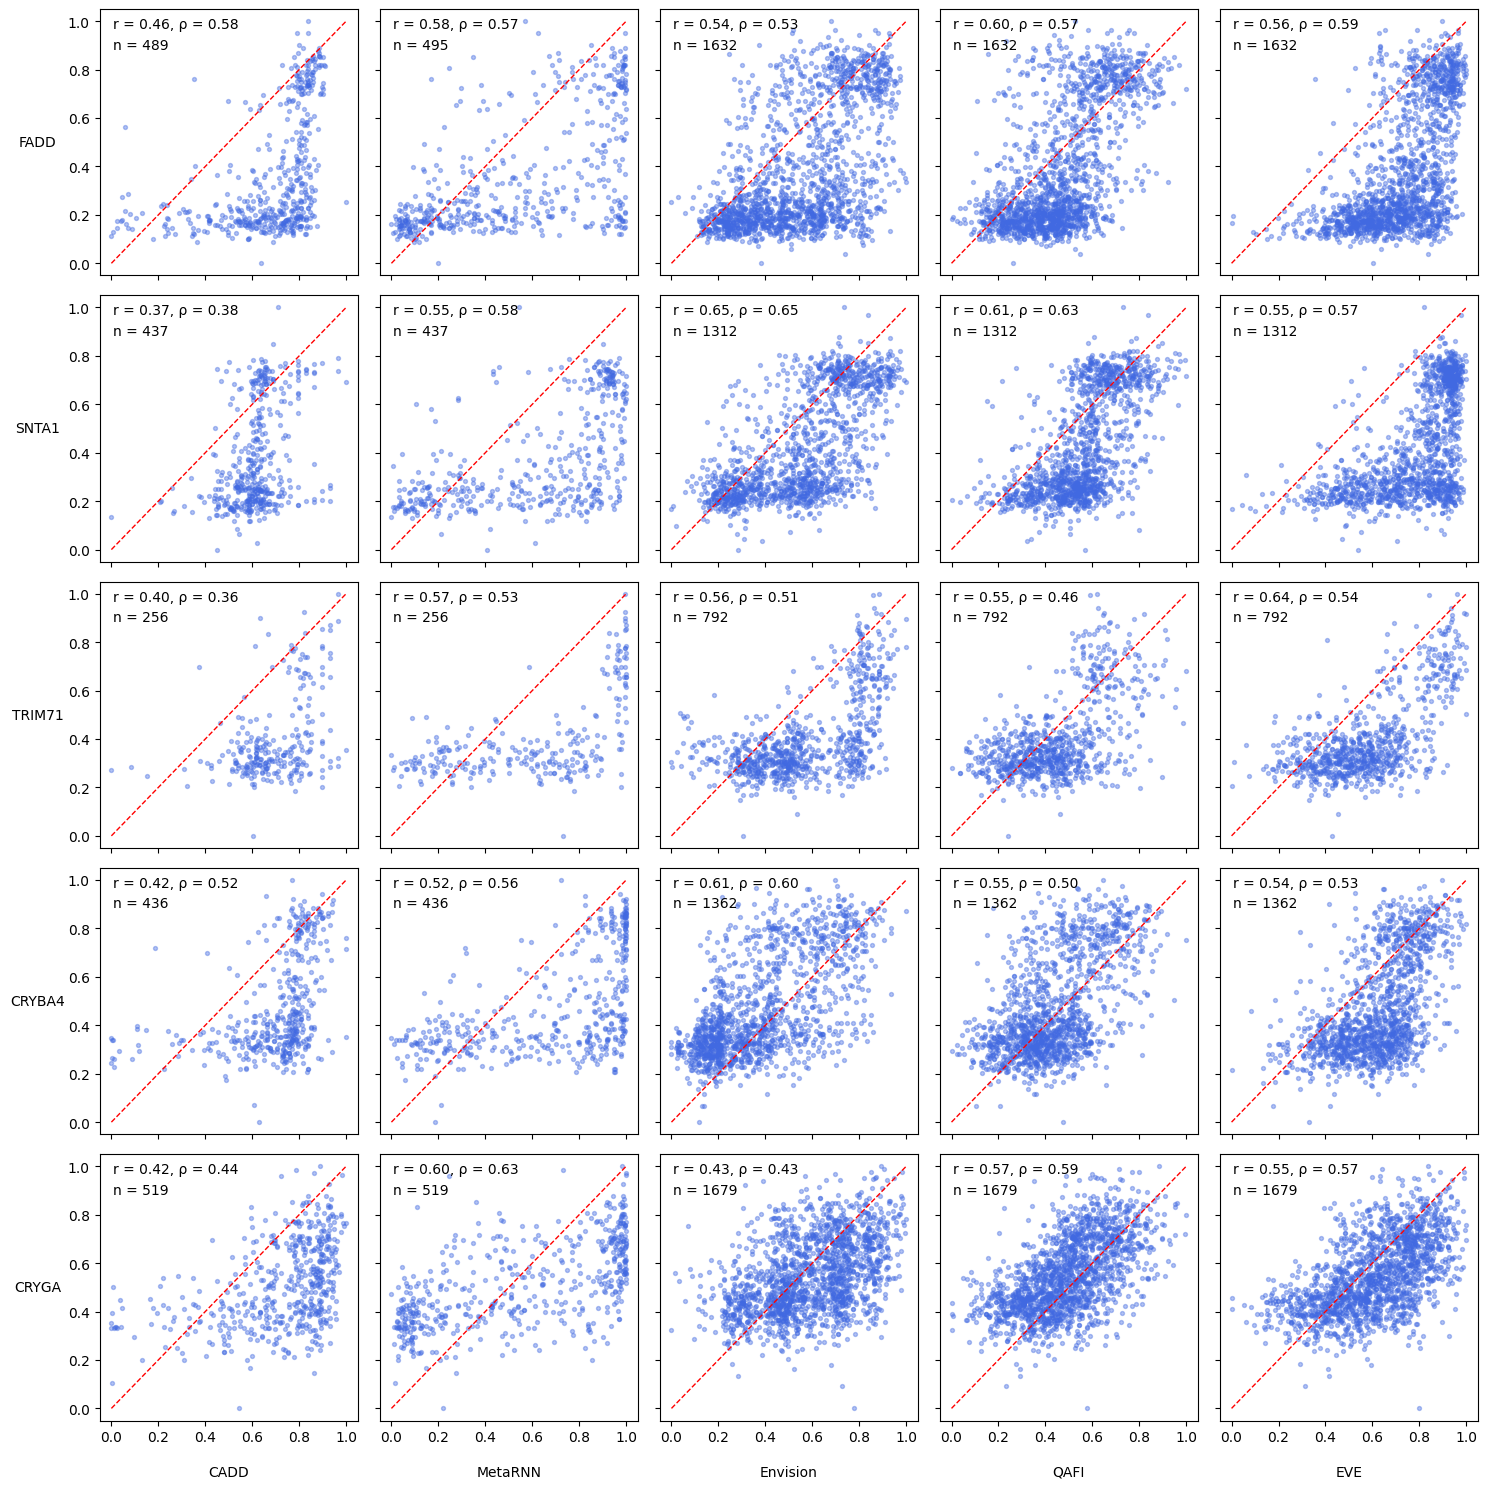

In [15]:
# 1) genes with data for all 5 predictors
avail = (
    final_dms_data
    .groupby('gene_name')[preds]
    .apply(lambda df: df.notna().all(axis=1).sum())
)
full_genes = avail[avail > 0].index  # genes with at least 1 variant in each predictor

# 2) compute mean Pearson r per gene
mean_r = (
    pd.DataFrame(results)  # results from earlier loop: gene, predictor, r, rho
    .query("gene in @full_genes")
    .groupby('gene')['r']
    .mean()
)
top5 = mean_r.sort_values(ascending=False).head(5).index.tolist()

# 3) plot grid for those top5 genes
scaler = MinMaxScaler()
fig, axes = plt.subplots(5, 5, figsize=(15,15), sharex=True, sharey=True)

for i, gene in enumerate(top5):
    gdata = final_dms_data[final_dms_data['gene_name']==gene]
    for j, pred in enumerate(preds):
        ax = axes[i,j]
        sub = gdata[['normalized_fitness', pred]].dropna()
        if sub.empty:
            ax.axis('off')
            continue

        # scale & plot
        x = scaler.fit_transform(sub[[pred]])
        y = scaler.fit_transform(sub[['normalized_fitness']])
        ax.scatter(x, y, s=8, alpha=0.4, color='royalblue')
        ax.plot([0,1],[0,1],'r--',lw=1)

        # compute stats
        n = len(sub)
        r, _ = pearsonr(x.flatten(), y.flatten())
        rho, _ = spearmanr(x.flatten(), y.flatten())

        # annotate metrics and n
        ax.text(0.05, 0.97, f"r = {r:.2f}, ρ = {rho:.2f}",
                transform=ax.transAxes, va='top', ha='left', fontsize=10)
        ax.text(0.05, 0.84, f"n = {n}",
                transform=ax.transAxes, va='bottom', ha='left', fontsize=10)

        # labels
        if i==4: ax.set_xlabel(pred, labelpad=20, va="center", fontsize=10)
        if j==0: ax.set_ylabel(gene, rotation=0, labelpad=22, va="center", fontsize=10)

plt.tight_layout()
plt.savefig("scatter_matrix_Block1Part1.svg", format="svg")
plt.show()

Each panel is one predictor (columns) against one protein (rows).

- Axes: X = scaled predictor score; Y = scaled DMS fitness.

- Dashed diagonal: perfect agreement (predictor≈experiment).

- “r = …, ρ = …, n = …” (top-left) tells Pearson r, Spearman ρ, and sample size.

To read:

- Find a protein row we care about, then scan across predictors to see which cloud **hugs** the diagonal best and has the **highest r/ρ**.

- Or pick predictor column to compare its performance across proteins by seeing where points lie closest to the diagonal and checking each panel’s r/ρ.

Dots above vs. below the diagonal

- Above the y = x line: the predictor overestimates functional impact (predicts more damaging than the DMS assay shows).

- Below the line: the predictor underestimates damage (calls variants more benign than the assay).

Across the top genes, QAFI and MetaRNN most tightly hug the diagonal (highest r/ρ), meaning they best recapitulate the DMS‐measured fitness. EVE and CADD tend to under- or over-estimate more often.


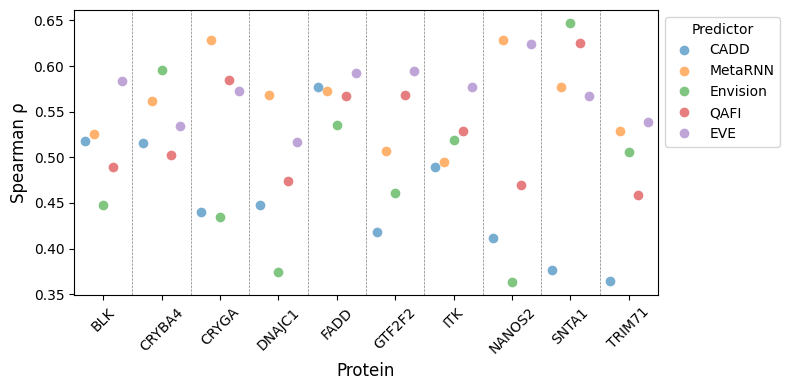

In [17]:
# 1) genes with data for all predictors
avail = (
    final_dms_data
    .groupby('gene_name')[preds]
    .apply(lambda df: df.notna().all(axis=1).sum())
)
full_genes = avail[avail > 0].index

# 2) compute per-gene, per-predictor Spearman
rows = []
for gene in full_genes:
    sub = final_dms_data[final_dms_data['gene_name']==gene]
    for p in preds:
        x = sub[p]; y = sub['normalized_fitness']
        rho, _ = spearmanr(x, y, nan_policy='omit')
        rows.append({'gene': gene, 'predictor': p, 'rho': rho})
df = pd.DataFrame(rows)

# 3) select top 10 by mean rho
top10 = (
    df.groupby('gene')['rho']
      .mean()
      .nlargest(10)
      .index
      .tolist()
)
df2 = df[df['gene'].isin(top10)]

# 4) plot
plt.figure(figsize=(8,4))
sns.stripplot(
    data=df2, x='gene', y='rho', hue='predictor',
    dodge=True, size=7, alpha=0.6
)

ax = plt.gca()
n = len(top10)
for i in range(n-1):
    ax.axvline(i+0.5, color='gray', linestyle='--', linewidth=0.5)

plt.xticks(rotation=45)
plt.ylabel("Spearman ρ", fontsize=12)
plt.xlabel("Protein", fontsize=12)
plt.legend(title="Predictor", bbox_to_anchor=(1,1))
plt.tight_layout()
plt.savefig("dot_plot_Block1Part1.svg", format="svg")
plt.show()

Spearman's correlation calculated between all variant effect predictions and DMS data sets. The top‐performing predictor for each protein is labelled on the plot. 